# Exploratory Data Analysis  

In this section, we conduct **Exploratory Data Analysis (EDA)** to understand the structure, patterns, and potential insights within our dataset. EDA helps us identify data quality issues, correlations, distributions, and trends before proceeding to feature engineering and modeling.  

### Steps Covered:  
1. **Data Overview** – Loading the dataset and examining its structure, types, and missing values.  
2. **Statistical Summary** – Generating summary statistics to understand distributions, central tendencies, and variances.  
3. **Data Visualization** – Creating histograms, box plots, pair plots, and correlation heatmaps to identify patterns and outliers.  
4. **Feature Relationships** – Analyzing dependencies between features using correlation matrices and scatter plots.  

EDA provides the foundation for informed feature selection and model development, ensuring our dataset is well-prepared for machine learning workflows.  


In [1]:
!pip install seaborn matplotlib --quiet

In [2]:
# Data Analysis
import kagglehub
import pandas as pd
from io import StringIO

# AWS Imports
import boto3
from botocore.client import ClientError
import sagemaker
from pyathena import connect
import awswrangler as wr

import matplotlib.pyplot as plt
import seaborn as sns
import os

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Read Data From the Bucket

In [4]:
# Create a SageMaker session object, which is used to manage interactions with SageMaker resources.
sess = sagemaker.Session()

# Retrieve the default Amazon S3 bucket associated with the SageMaker session.
bucket = sess.default_bucket()

# Get the IAM role associated with the current SageMaker notebook or environment.
role = sagemaker.get_execution_role()

# Get the AWS region name for the current session.
region = boto3.Session().region_name

# Retrieve the AWS account ID of the caller using the Security Token Service (STS) client.
account_id = boto3.client("sts").get_caller_identity().get("Account")

# Create a Boto3 client for the SageMaker service, specifying the AWS region.
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

file_key = "aai-540-group-3-final-project/data/eda/data.csv"

# Create an S3 client
s3 = boto3.client('s3')

In [5]:
# Initializing variables for reproducibility
FILE_NAME="data.csv"
DATA_SOURCE="db_source"
DATA_FOLDER =f"s3://{bucket}/aai-540-group-3-final-project/data/"
FILE_LOCATION=f"{DATA_FOLDER}{FILE_NAME}"
DATA_PATH = f"{DATA_FOLDER}{DATA_SOURCE}/"
DATABASE = "retainAI"
PROD_DIR = f"s3://{bucket}/athena/prod"
STAGE_DIR = f"s3://{bucket}/athena/staging"
EMPLOYEE_TABLE = "employee_table"

# Making sure all variables are correct
print(f"File location with all the data: {FILE_LOCATION}")
print(f"Data Path for database creation: {DATA_PATH}")
print(f"Production and Staging Database Directories: {PROD_DIR},{STAGE_DIR}")
print(f"Database Name, Training Table and Testing Table: {DATABASE}, {EMPLOYEE_TABLE}")

File location with all the data: s3://sagemaker-us-east-1-796598873577/aai-540-group-3-final-project/data/data.csv
Data Path for database creation: s3://sagemaker-us-east-1-796598873577/aai-540-group-3-final-project/data/db_source/
Production and Staging Database Directories: s3://sagemaker-us-east-1-796598873577/athena/prod,s3://sagemaker-us-east-1-796598873577/athena/staging
Database Name, Training Table and Testing Table: retainAI, employee_table


In [6]:
# check what is in DATA_FOLDER
!aws s3 ls $DATA_FOLDER --recursive

2025-02-16 21:03:39    2616747 aai-540-group-3-final-project/data/db_source/remaining_data.csv
2025-02-16 21:03:43    9550295 aai-540-group-3-final-project/data/eda/data.csv
2025-02-16 21:03:41    1744315 aai-540-group-3-final-project/data/holdout/holdout.csv


## Data Overview
Attrition --> 1 = Stayed, 0 = Left

In [7]:
# Download the file from S3 to a local file object
response = s3.get_object(Bucket=bucket, Key=file_key)

# Read the content of the file into a pandas DataFrame
data = pd.read_csv(response['Body'])

# Display the DataFrame
display(data)

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,...,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,...,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159,Good,High,Low,0,...,3,Mid,Medium,74,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989,Good,High,High,1,...,2,Mid,Small,50,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821,Fair,Very High,Average,0,...,0,Senior,Medium,68,No,No,No,Fair,Medium,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74493,16243,56,Female,42,Healthcare,7830,Poor,Medium,Average,0,...,0,Senior,Medium,60,No,No,No,Poor,Medium,Stayed
74494,47175,30,Female,15,Education,3856,Good,Medium,Average,2,...,0,Entry,Medium,20,No,No,No,Good,Medium,Left
74495,12409,52,Male,5,Education,5654,Good,Very High,Below Average,0,...,4,Mid,Small,7,No,No,No,Good,High,Left
74496,9554,18,Male,4,Education,5276,Fair,High,Average,0,...,3,Mid,Large,5,No,No,No,Poor,High,Stayed


## Statistical Summary

In [8]:
# Display basic statistics
display(data.describe(include='all'))

# Check for missing values
display("Missing values:")
display(data.isnull().sum())

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
count,74498.000000,74498.000000,74498,74498.000000,74498,74498.000000,74498,74498,74498,74498.000000,...,74498.000000,74498,74498,74498.000000,74498,74498,74498,74498,74498,74498
unique,NaN,NaN,2,NaN,5,NaN,4,4,4,NaN,...,NaN,3,3,NaN,2,2,2,4,4,2
top,NaN,NaN,Male,NaN,Technology,NaN,Good,High,Average,NaN,...,NaN,Entry,Medium,NaN,No,No,No,Good,Low,Stayed
freq,NaN,NaN,40826,NaN,19322,NaN,28158,37245,44719,NaN,...,NaN,29780,37231,NaN,60300,70845,62394,37182,29620,39128
mean,37249.500000,38.529746,NaN,15.721603,NaN,7299.379514,NaN,NaN,NaN,0.832935,...,1.650326,NaN,NaN,55.727456,NaN,NaN,NaN,NaN,NaN,NaN
std,21505.864514,12.083456,NaN,11.223744,NaN,2152.508566,NaN,NaN,NaN,0.995289,...,1.553633,NaN,NaN,25.399349,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,18.000000,NaN,1.000000,NaN,1226.000000,NaN,NaN,NaN,0.000000,...,0.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,18625.250000,28.000000,NaN,7.000000,NaN,5652.000000,NaN,NaN,NaN,0.000000,...,0.000000,NaN,NaN,36.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,37249.500000,39.000000,NaN,13.000000,NaN,7348.000000,NaN,NaN,NaN,1.000000,...,1.000000,NaN,NaN,56.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,55873.750000,49.000000,NaN,23.000000,NaN,8876.000000,NaN,NaN,NaN,2.000000,...,3.000000,NaN,NaN,76.000000,NaN,NaN,NaN,NaN,NaN,NaN


'Missing values:'

Employee ID                 0
Age                         0
Gender                      0
Years at Company            0
Job Role                    0
Monthly Income              0
Work-Life Balance           0
Job Satisfaction            0
Performance Rating          0
Number of Promotions        0
Overtime                    0
Distance from Home          0
Education Level             0
Marital Status              0
Number of Dependents        0
Job Level                   0
Company Size                0
Company Tenure              0
Remote Work                 0
Leadership Opportunities    0
Innovation Opportunities    0
Company Reputation          0
Employee Recognition        0
Attrition                   0
dtype: int64

### Data Quality Assessment and Justification for Moving Forward

The results of the data quality checks indicate that the dataset is complete and ready for further analysis. Below are the reasons why we can confidently move on from this stage:

1. **No Missing Values**:
   - The dataset contains no missing values in any of the 24 features.
   - This eliminates the need for imputation or synthetic data generation, saving time and ensuring the dataset’s integrity remains intact.

2. **Comprehensive Dataset**:
   - The dataset provides a rich set of features, including numerical attributes (e.g., `Age`, `Monthly Income`, `Years at Company`) and categorical attributes (e.g., `Gender`, `Job Role`, `Marital Status`).
   - This diversity of features ensures we have enough information to perform meaningful analysis or build predictive models.

3. **No Immediate Data Cleaning Needed**:
   - There are no apparent issues, such as missing or inconsistent data, that would require preprocessing.
   - The data is already in a usable format, which allows us to focus on feature engineering, exploratory data analysis (EDA), and modeling.

4. **Well-Structured Columns**:
   - Each column has a clear and meaningful label, making it easy to understand and interpret the dataset.
   - Categorical features are in a format suitable for encoding, and numerical features appear to be properly scaled (to be confirmed during model preparation).


## Data Visualization


Target variable distribution:


Attrition
Stayed    39128
Left      35370
Name: count, dtype: int64

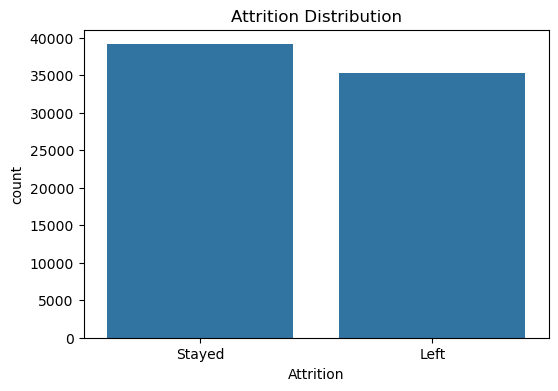

In [9]:
# Explore target variable distribution
print("\nTarget variable distribution:")
display(data['Attrition'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='Attrition', data=data)
plt.title('Attrition Distribution')
plt.show()

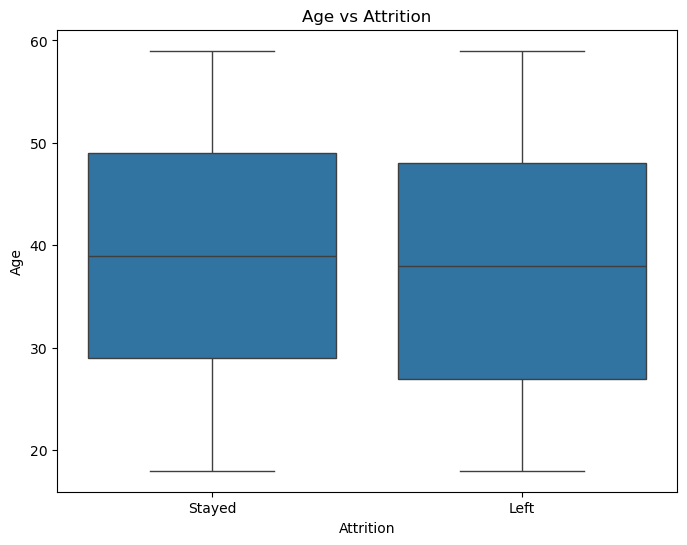

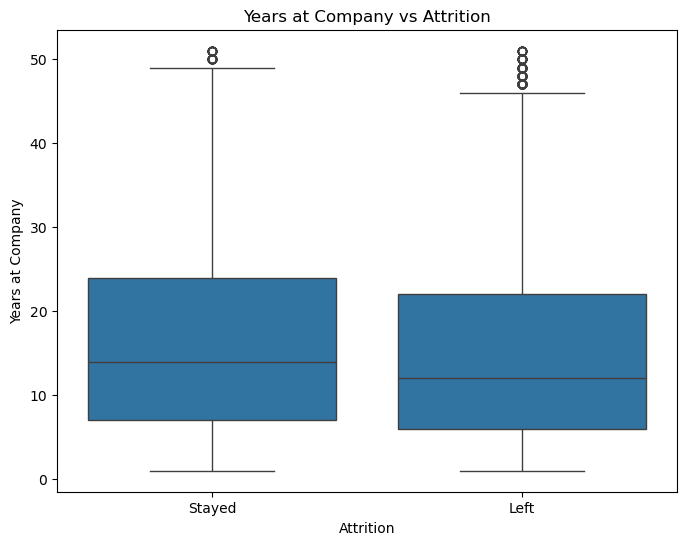

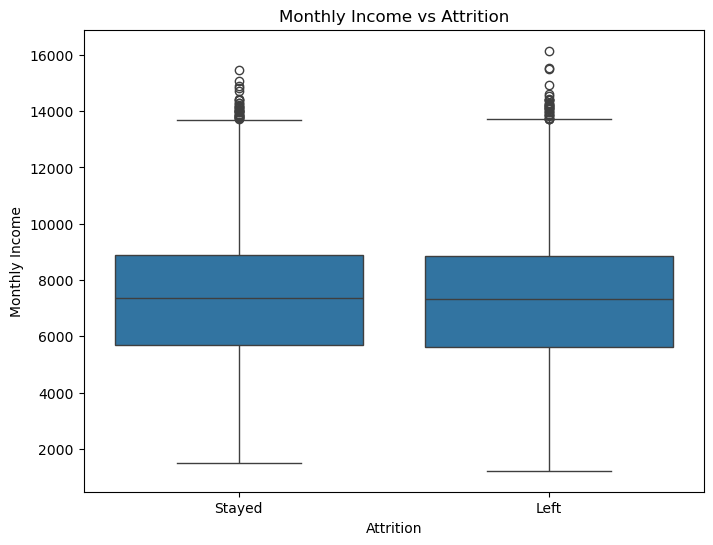

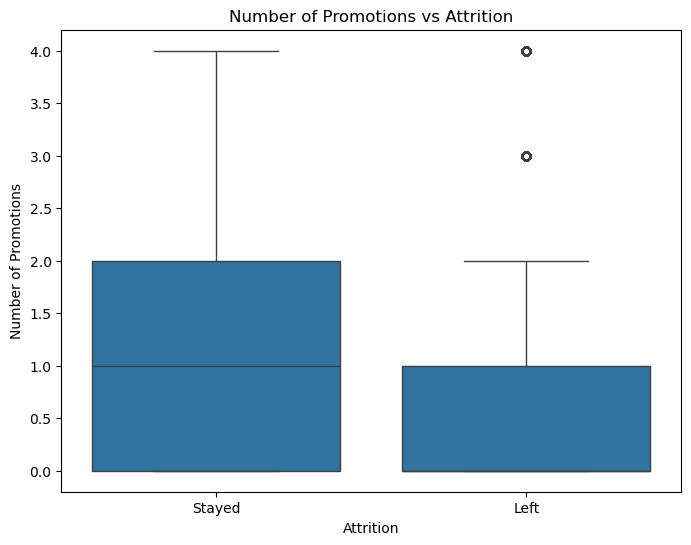

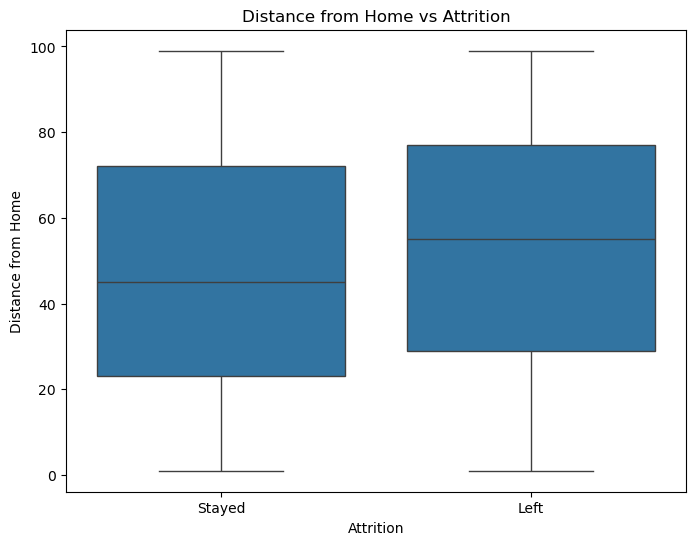

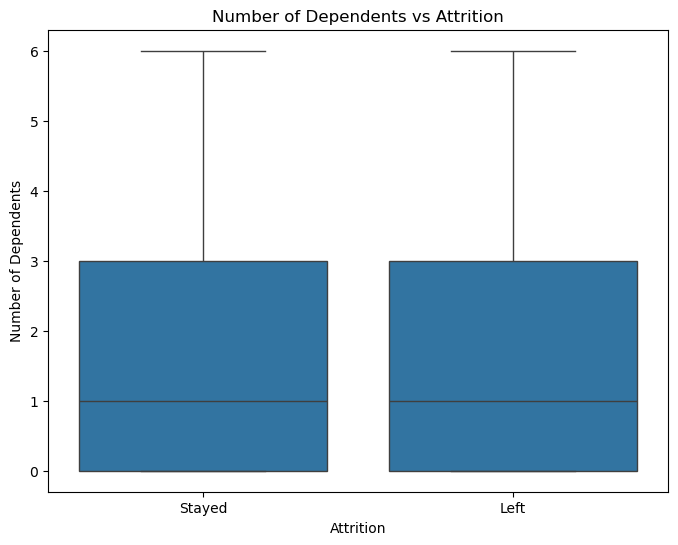

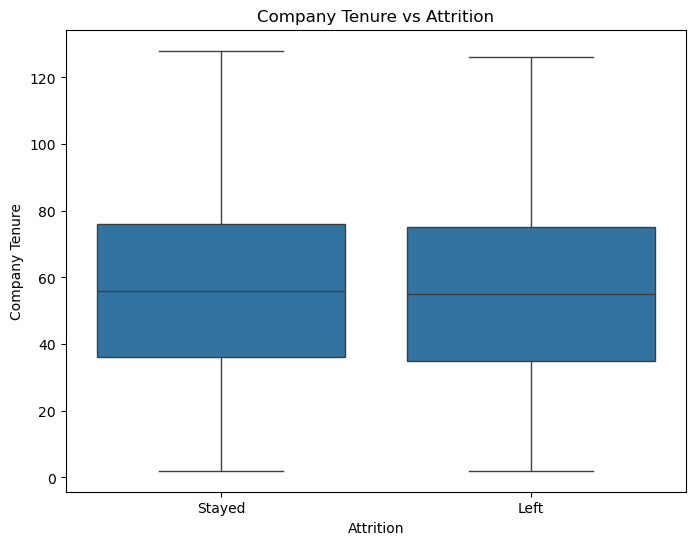

In [10]:
# Analyze relationships between features and target variable
numerical_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

for col in numerical_cols:
  if col != 'Employee ID': #Exclude Employee ID
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Attrition', y=col, data=data)
    plt.title(f'{col} vs Attrition')
    plt.show()

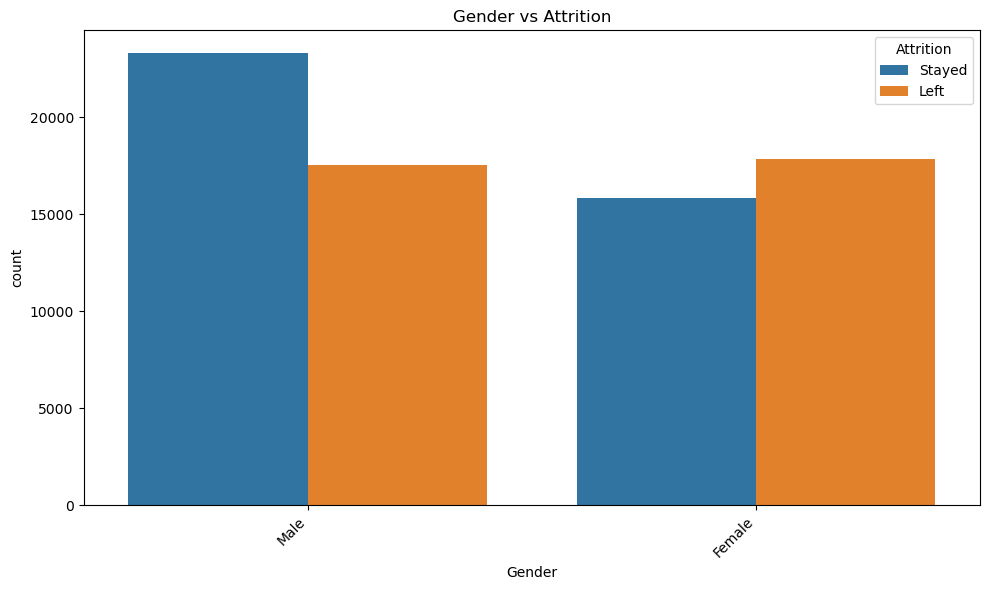

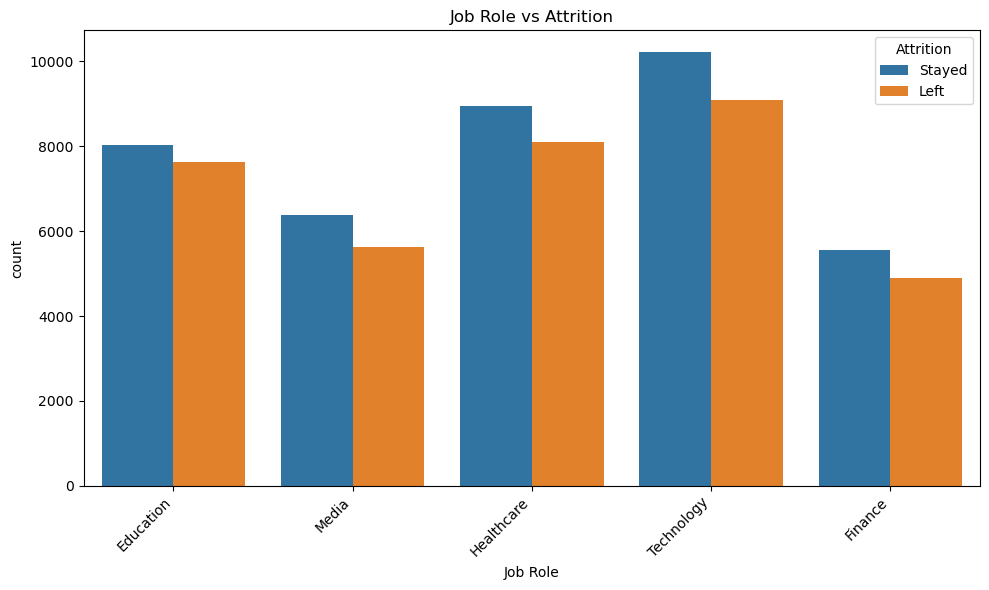

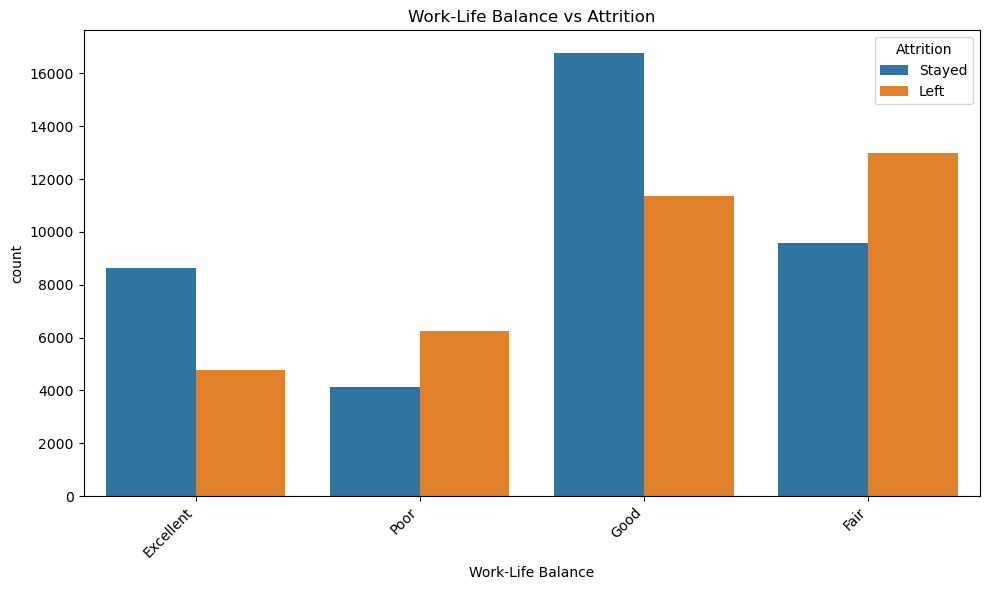

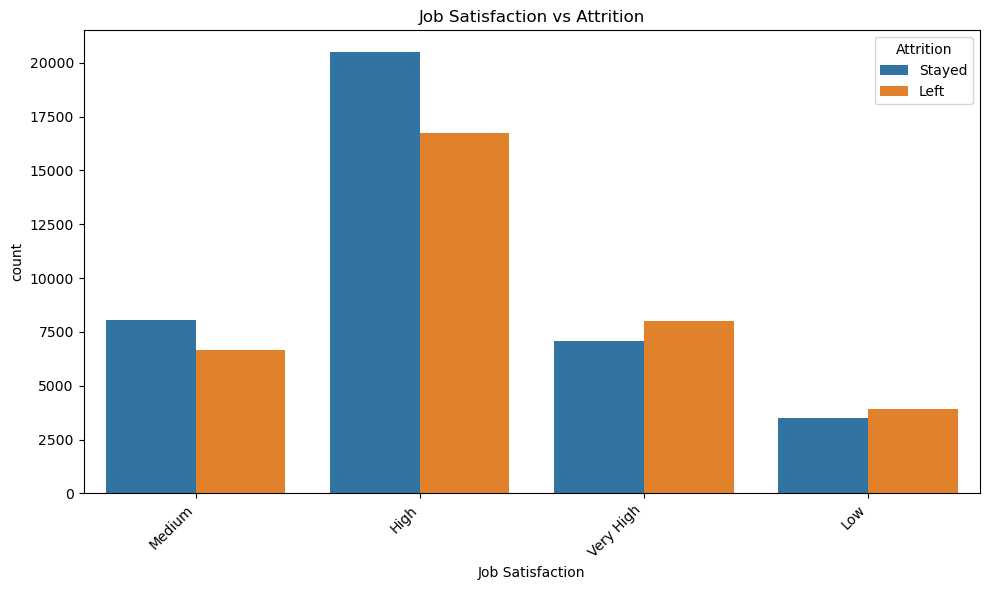

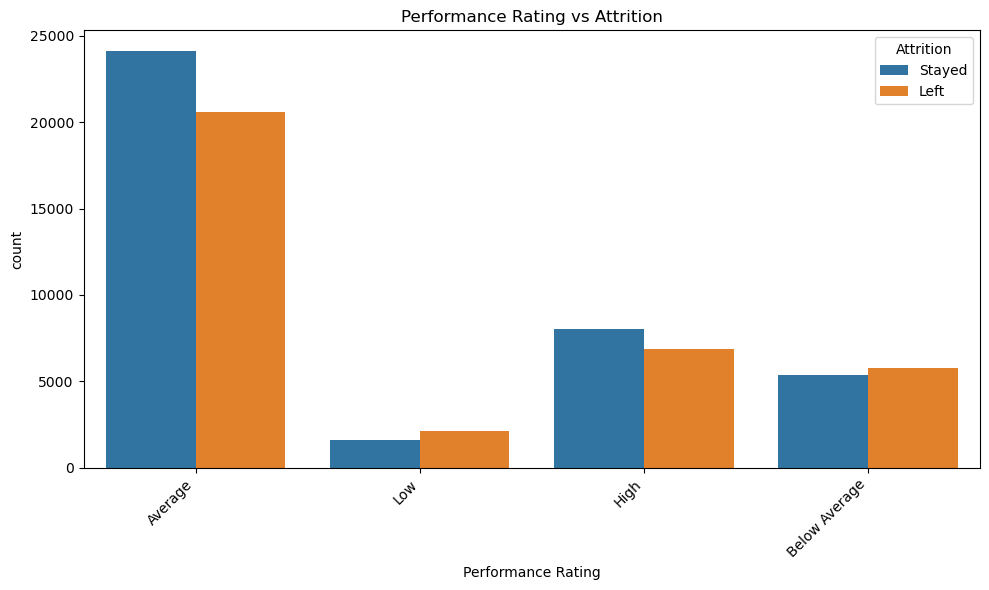

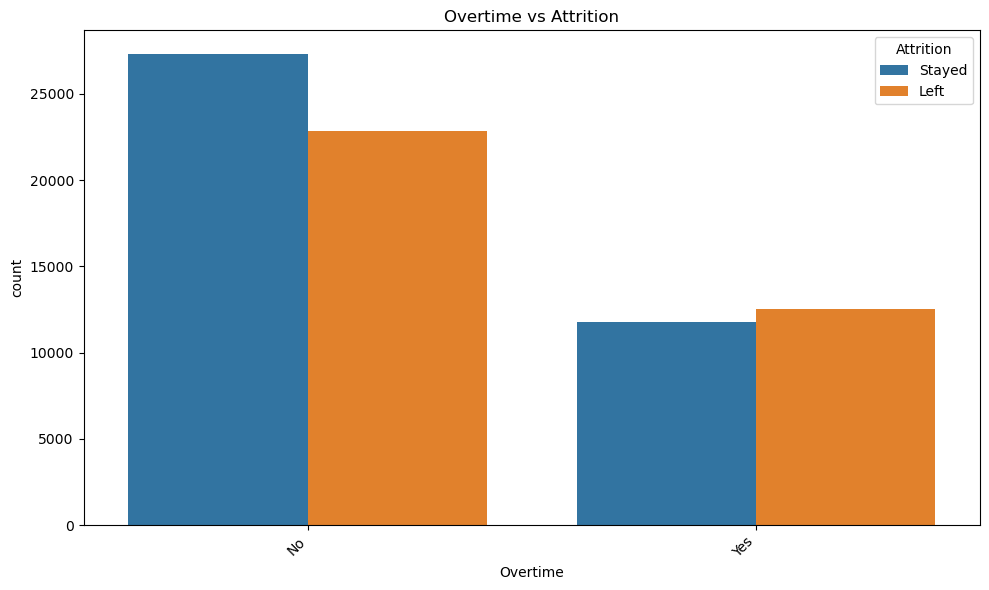

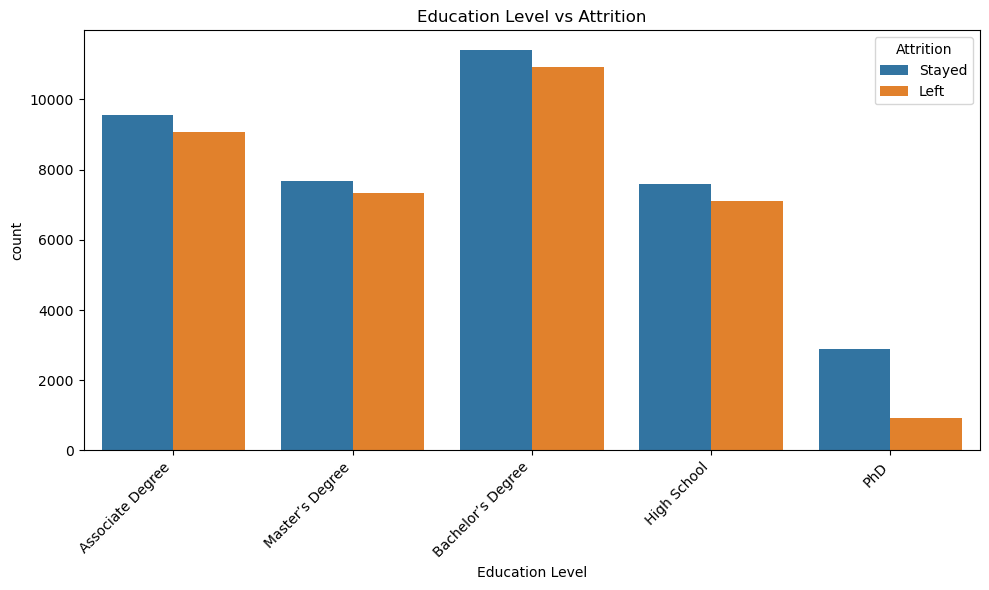

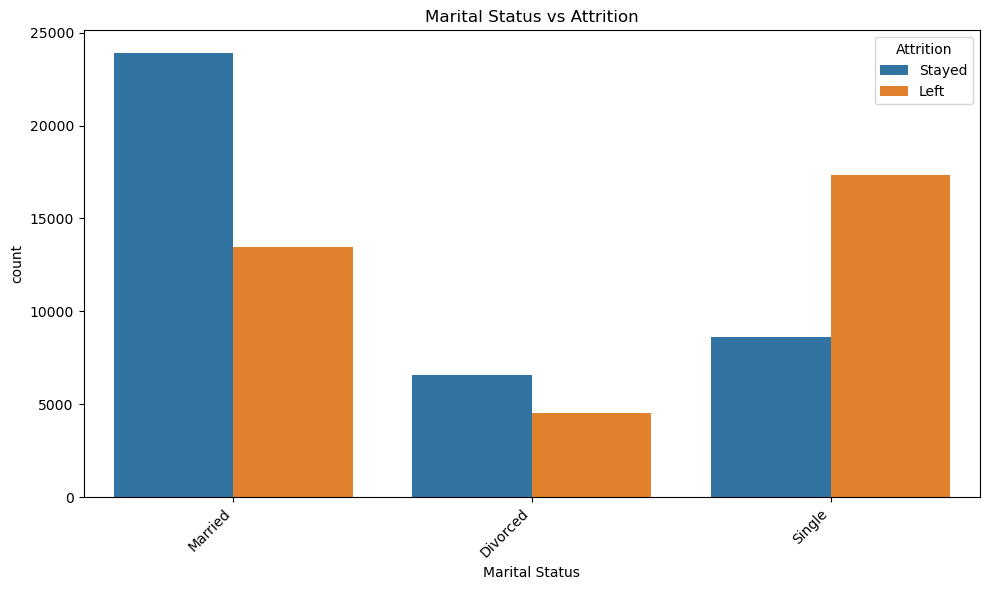

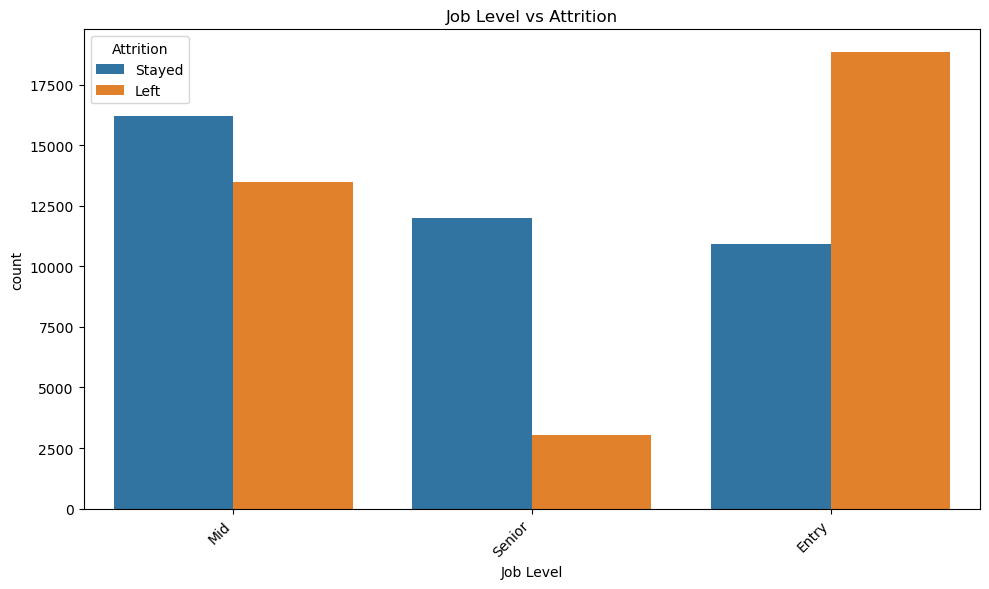

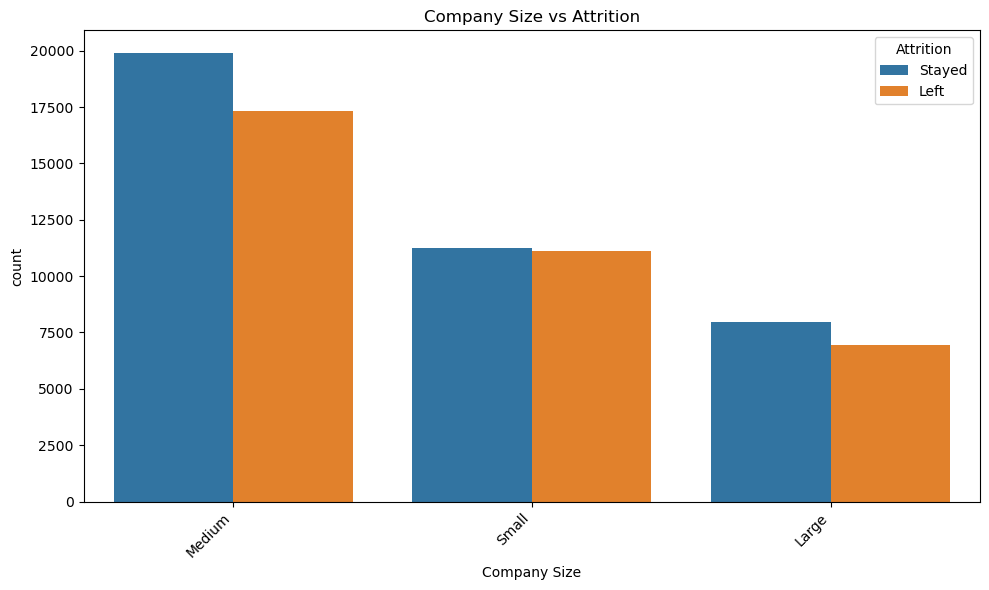

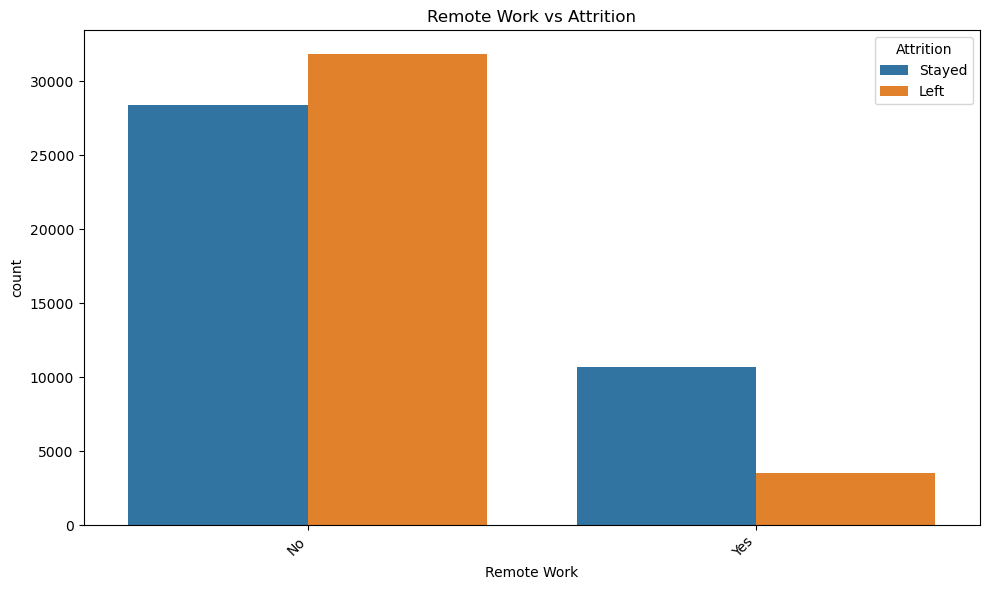

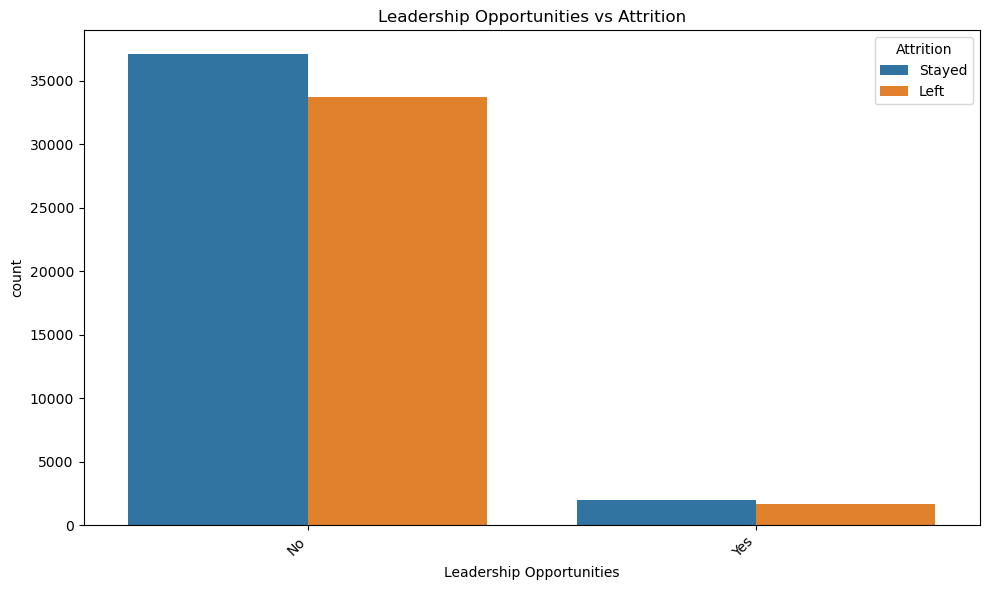

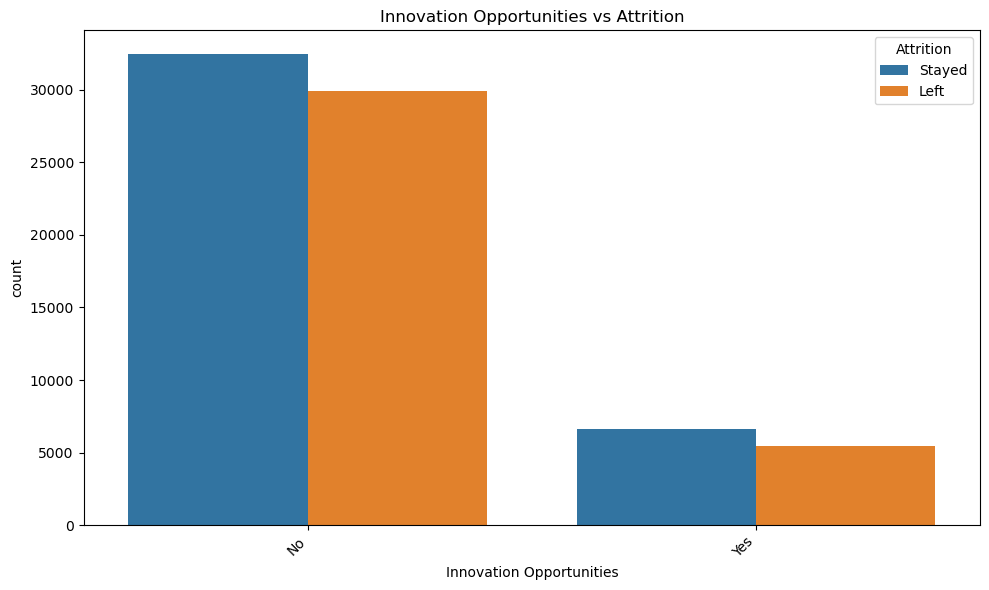

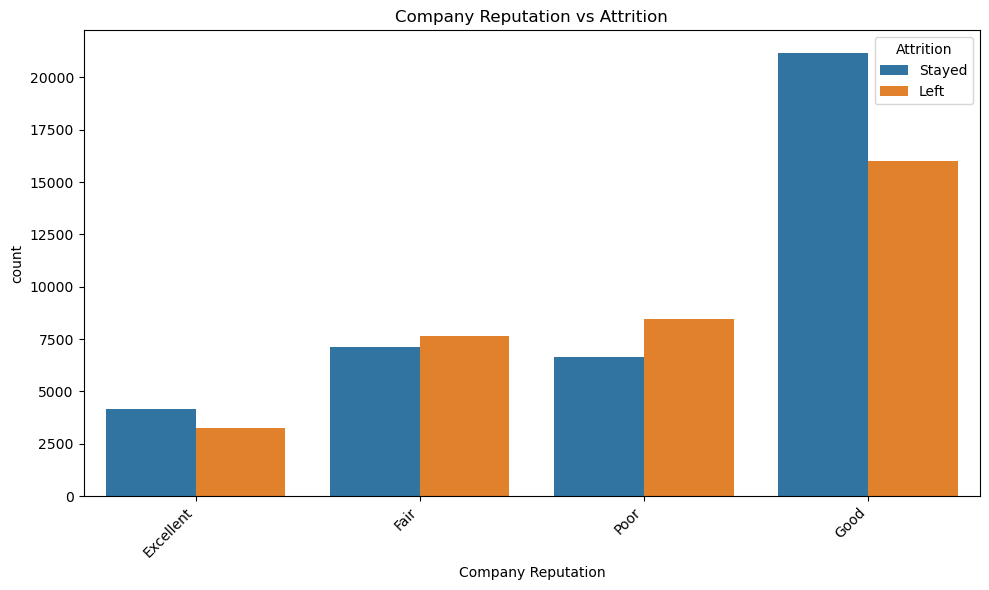

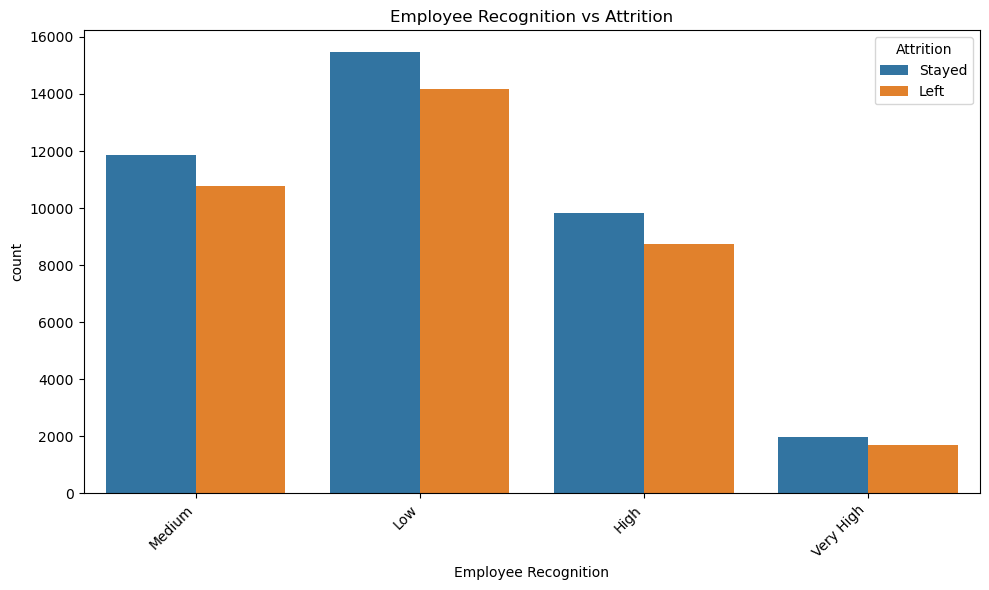

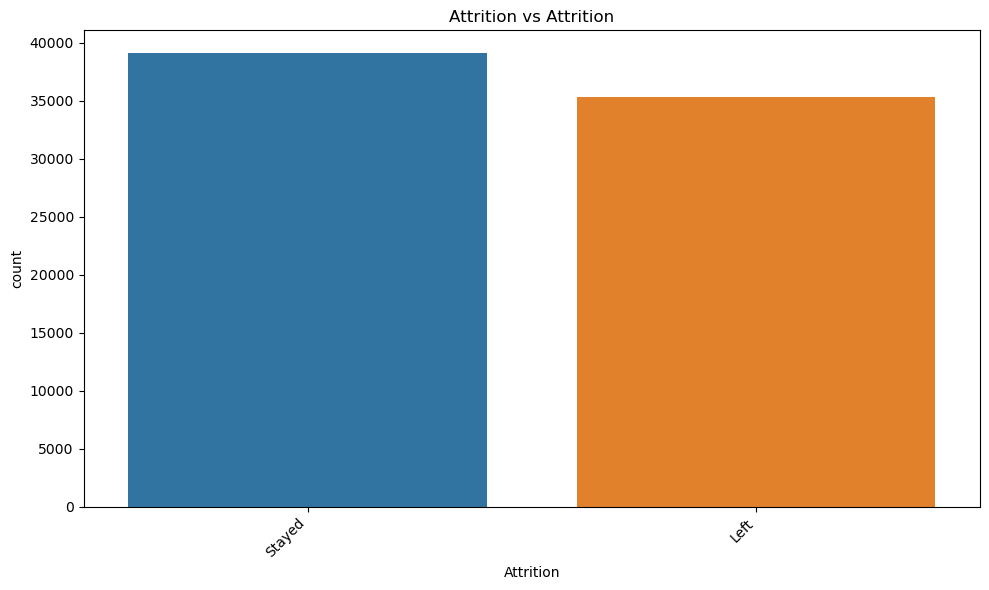

In [11]:
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Attrition', data=data)
    plt.title(f'{col} vs Attrition')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

## Feature Relationships

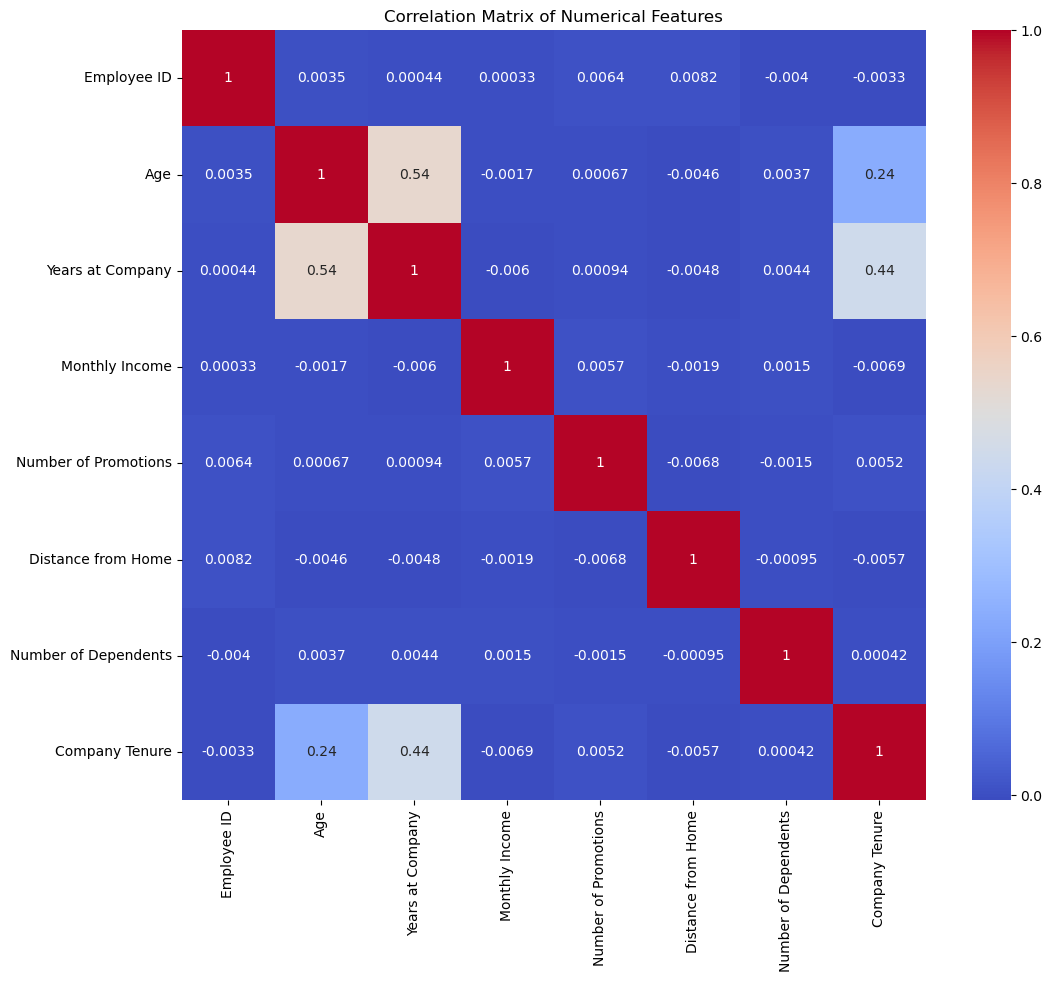

In [12]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 10))
correlation_matrix = data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Analysis of the Correlation Matrix

The correlation matrix provides insights into the relationships between numerical features in the dataset. Below are key observations and interpretations based on the analysis:

1. **Moderate Positive Correlation between "Age" and "Years at Company" (0.54):**
   - This suggests that older employees tend to have been at the company for a longer duration. While this relationship is expected, it is not perfect, indicating that tenure at the company is not solely determined by age. This feature pair might not require immediate action but could be revisited if multicollinearity impacts model performance.

2. **Moderate Correlation between "Years at Company" and "Company Tenure" (0.44):**
   - The correlation indicates some overlap in the information these features capture, as both relate to an employee's time at the company. Depending on the analysis goal, it may be beneficial to:
     - Retain both features if their distinct contributions to the model are important.
     - Combine them into a single feature (e.g., an average or weighted value) to reduce redundancy.

3. **Weak or Negligible Correlations among Most Features:**
   - Other feature pairs exhibit very low correlation values (close to 0), indicating they are largely independent of one another. For example:
     - "Monthly Income" and "Number of Promotions" have almost no correlation.
     - "Distance from Home" and "Number of Dependents" are also uncorrelated.
   - These independent features are valuable for predictive modeling as they provide unique information.

4. **Independent Features for Model Inclusion:**
   - Features such as "Monthly Income," "Number of Promotions," "Distance from Home," and "Number of Dependents" are candidates for inclusion in models without concerns of multicollinearity. They contribute unique information to the dataset.

5. **Insights for Predictive Modeling:**
   - While "Employee ID" is included in the matrix, it is an identifier and does not contribute meaningful information for modeling. It should be excluded from predictive analyses.
   - Features with moderate correlations (e.g., "Years at Company" and "Company Tenure") should be carefully evaluated for redundancy or combined for simplicity.

6. **Handling Missing Values:**
   - If any features contain missing values, strategies such as imputation (e.g., mean, median, or mode) or synthetic data generation can be applied. The choice of method should align with the business context and maintain data integrity.

7. **Ethical Considerations for Sensitive Features:**
   - Features like "Age" and "Monthly Income" may raise ethical concerns if used in predictive modeling, particularly if the model impacts decisions related to hiring, promotions, or compensation. It is essential to:
     - Ensure these features are used only if they are critical to the analysis.
     - Validate that their inclusion does not introduce bias or violate fairness standards.

### Conclusion:
The correlation matrix highlights key relationships between features, such as the moderate overlap between "Years at Company" and "Company Tenure." Most features are independent, making them suitable for inclusion in predictive modeling. Careful handling of sensitive features and missing values will ensure the analysis is both effective and ethical.

### Ethical Considerations for Sensitive Features

#### Sensitive Features in the Dataset:
1. **Gender**
2. **Age**
3. **Marital Status**

#### Analysis and Justification:

1. **Gender**:
   - **Reason for Inclusion**:
     - Gender can impact certain analyses, such as understanding gender-based differences in attrition, job satisfaction, or work-life balance.
     - It might help organizations address disparities and implement fair policies.
   - **Potential Bias/Fairness Issues**:
     - Including gender in predictive models (e.g., attrition prediction) could lead to bias in decision-making, such as unfair treatment or stereotyping.
     - If not handled carefully, it could violate fairness and anti-discrimination principles.
   - **Recommendation**:
     - Include gender if the goal is to analyze disparities and improve equity.
     - Exclude gender from predictive models that might influence hiring, promotions, or other critical decisions.

---

2. **Age**:
   - **Reason for Inclusion**:
     - Age is directly related to experience, tenure, and career progression, making it relevant for workforce analysis.
     - It could help identify patterns such as attrition risk by age group.
   - **Potential Bias/Fairness Issues**:
     - Including age in models could introduce ageism, leading to unfair outcomes for older or younger employees.
     - There are legal and ethical considerations, such as compliance with anti-age discrimination laws.
   - **Recommendation**:
     - Retain age if it provides critical insights into employee behavior.
     - Carefully document its inclusion to ensure transparency and fairness.

---

3. **Marital Status**:
   - **Reason for Inclusion**:
     - Marital status might provide insights into work-life balance, job satisfaction, or attrition trends.
     - For example, single employees might have different needs compared to married employees.
   - **Potential Bias/Fairness Issues**:
     - Using marital status in decision-making could be seen as discriminatory.
     - Its relevance to most analyses is often limited and might not justify its inclusion.
   - **Recommendation**:
     - Exclude marital status unless there is a clear, justified reason for its inclusion.

## Release Resources

In [17]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}